In [1]:
import warnings
from itertools import product
from __future__ import division
import pandas as pd
import statsmodels.api as sm
import scipy.stats as sts
%pylab inline

warnings.filterwarnings("ignore")

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


/home/storm/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
rmw = pd.read_csv("WAG_C_M.csv", sep=";", index_col = ["month"], parse_dates=["month"], dayfirst=True)
rmw.tail()

,WAG_C_M
month,
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0
2016-07-01,35888.0
2016-08-01,34095.0


критерий Дикки-Фуллера 0.991850


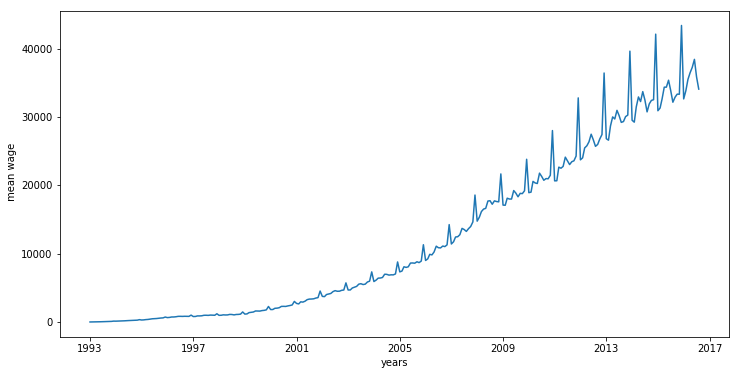

In [3]:
plt.figure(figsize=(12,6))
plt.plot(rmw.WAG_C_M)
plt.xlabel("years")
plt.ylabel(" mean wage")
print "критерий Дикки-Фуллера %f"% sm.tsa.stattools.adfuller(rmw.WAG_C_M)[1]

<Figure size 864x648 with 0 Axes>

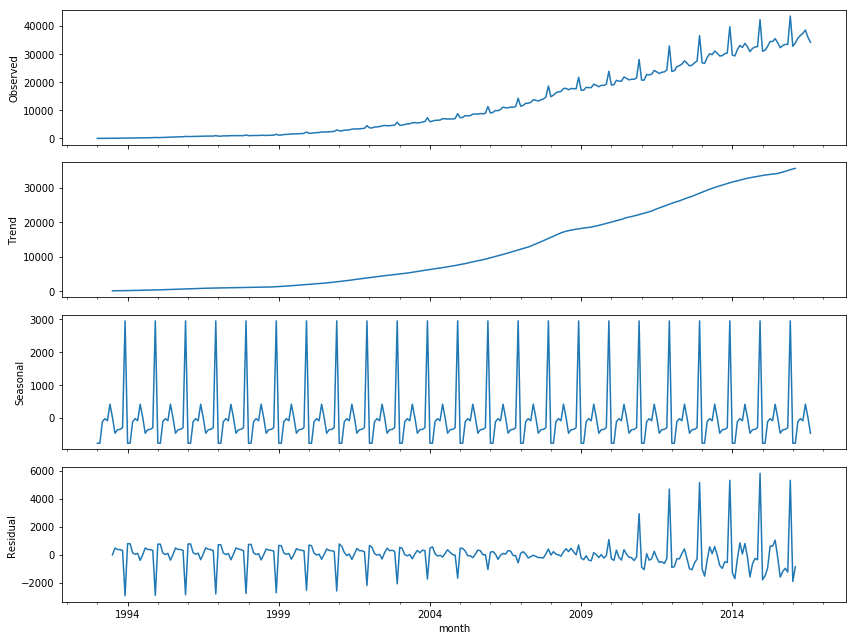

In [4]:
plt.figure(figsize(12,9))
sm.tsa.seasonal_decompose(rmw.WAG_C_M).plot()
plt.show()

Как видно в остатках кроме шума, есть логика, которую желательно уловить.

In [5]:
# ??sm.tsa

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
критерий Дикки-Фуллера :0.696899


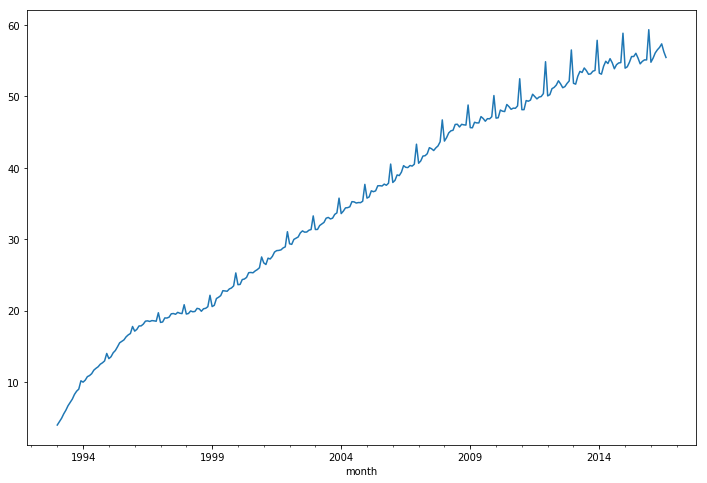

In [6]:
# Cтабилизация диспресии
rmw['wage_boxcox'], lmbda = sts.boxcox(rmw.WAG_C_M)
plt.figure(figsize(12,8))
rmw.wage_boxcox.plot()
print "Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda
print "критерий Дикки-Фуллера :%f"% sm.tsa.stattools.adfuller(rmw.wage_boxcox)[1]

критерий Дикки-Фуллера :0.014697


<Figure size 864x576 with 0 Axes>

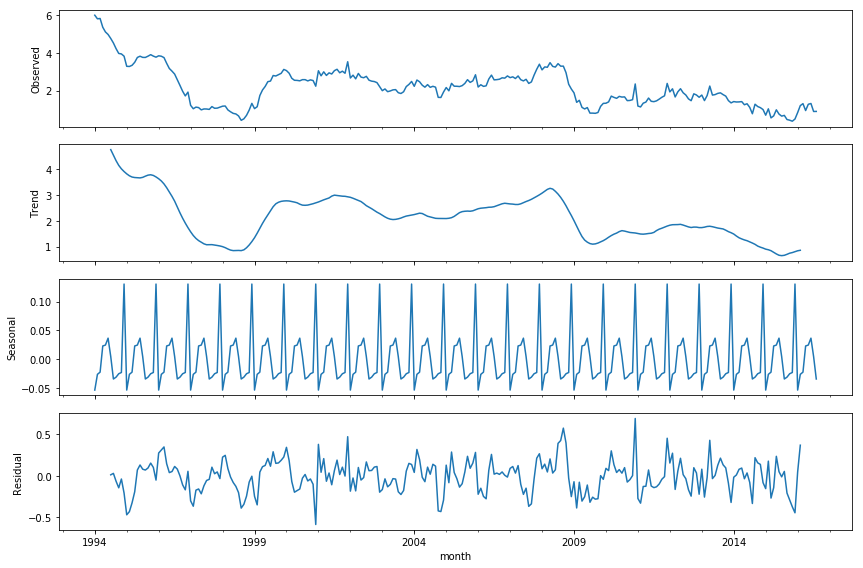

In [7]:
# Стационарность.

rmw["wage_diff12"] = rmw.wage_boxcox - rmw.wage_boxcox.shift(12)
plt.figure(figsize(12,8))
sm.tsa.seasonal_decompose(rmw.wage_diff12[12:]).plot()
print "критерий Дикки-Фуллера :%f"% sm.tsa.stattools.adfuller(rmw.wage_diff12[12:])[1]

Остатки стали больше походить на белый шум. Критерий Дикки-Фуллера отверагает H0. Но при этом на графике виден тренд, добавим обычно дифференцирование

критерий Дикки-Фуллера :0.000000


<Figure size 864x576 with 0 Axes>

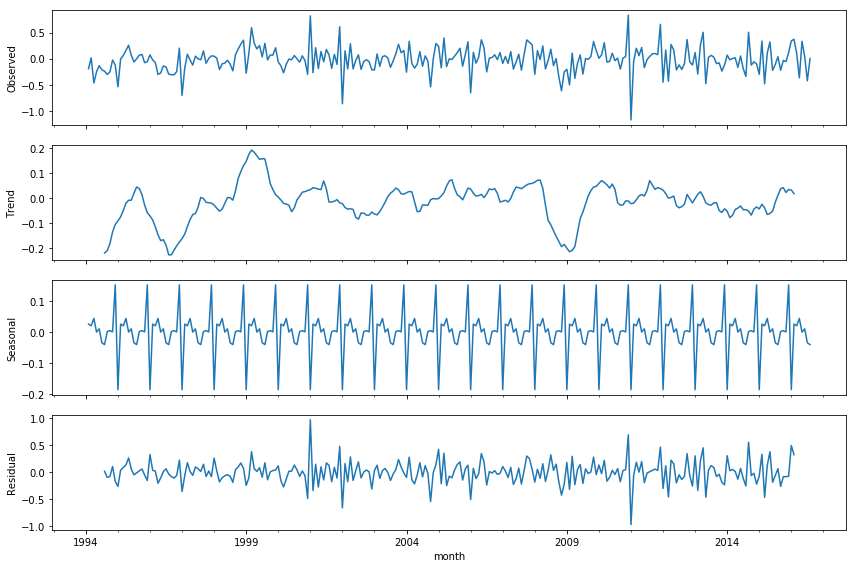

In [8]:
rmw["wage_diff1"] = rmw.wage_diff12 - rmw.wage_diff12.shift(1)
plt.figure(figsize(12,8))
sm.tsa.seasonal_decompose(rmw.wage_diff1[13:]).plot()
print "критерий Дикки-Фуллера :%f"% sm.tsa.stattools.adfuller(rmw.wage_diff1[13:])[1]

Можно сказать, что от глобального тренда мы избавились. Можно начинать искать приближения p, P, q, Q

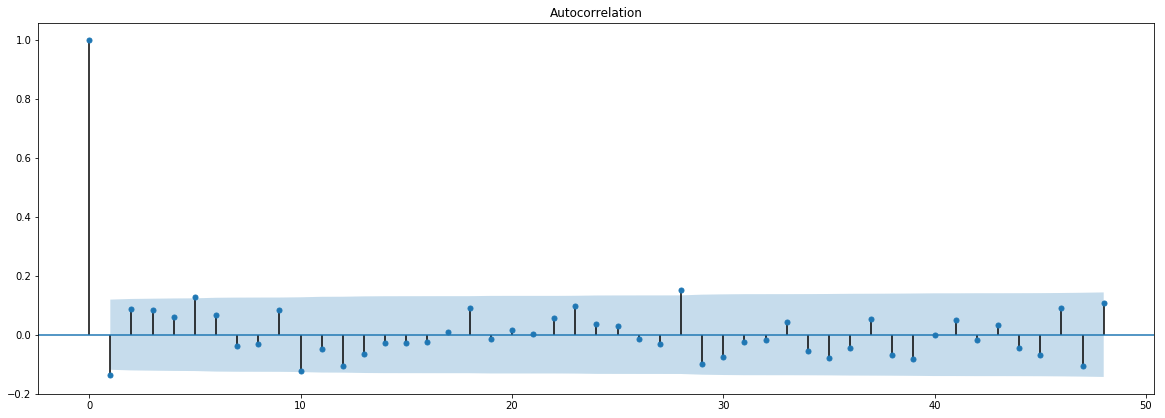

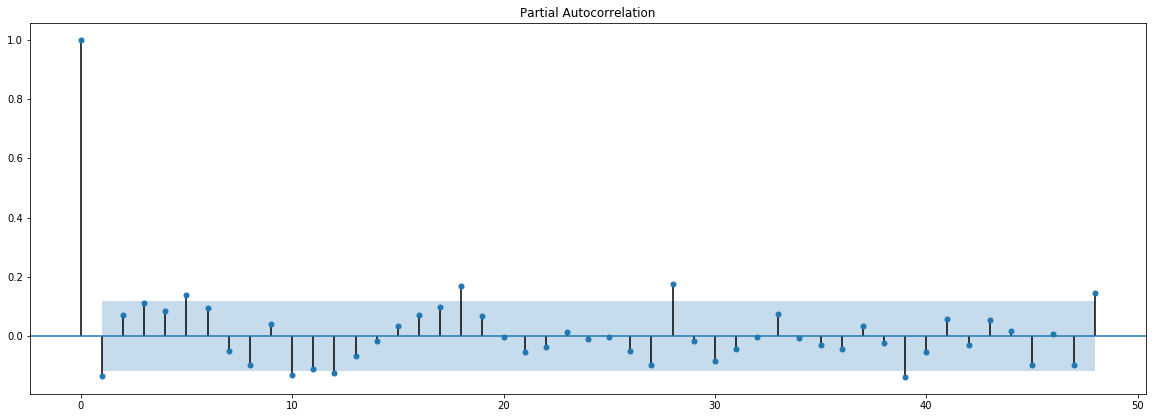

In [9]:
plt.figure(figsize(20,15))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(rmw.wage_diff1[13:].values.squeeze(), lags=48, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(rmw.wage_diff1[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

In [10]:
import itertools
Q, q, P, p, D, d =  1, 0, 1, 3, 1, 1
Qs, qs, Ps, ps = range(0,Q+1), range(0,q+1), range(0,P+1), range(0,p+1)

params = itertools.product(Qs, qs, Ps,ps)

results = list()
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in params:
    try:
        model=sm.tsa.statespace.SARIMAX(rmw.wage_boxcox, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
        
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [11]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
6   (0, 0, 1, 2) -3.180523
12  (1, 0, 1, 0)  0.340521
13  (1, 0, 1, 1)  0.492412
9   (1, 0, 0, 1)  0.774438
10  (1, 0, 0, 2)  2.075553


In [12]:
print best_model.summary()

                                 Statespace Model Results                                 
Dep. Variable:                        wage_boxcox   No. Observations:                  284
Model:             SARIMAX(0, 1, 0)x(1, 1, 2, 12)   Log Likelihood                   5.590
Date:                            Sat, 22 Dec 2018   AIC                             -3.181
Time:                                    17:26:08   BIC                             11.228
Sample:                                01-01-1993   HQIC                             2.605
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9992      0.045     22.090      0.000       0.911       1.088
ma.S.L12      -1.2309      0.373   

Критерий Стьюдента: p=0.767605
Критерий Дики-Фуллера: p=0.000156


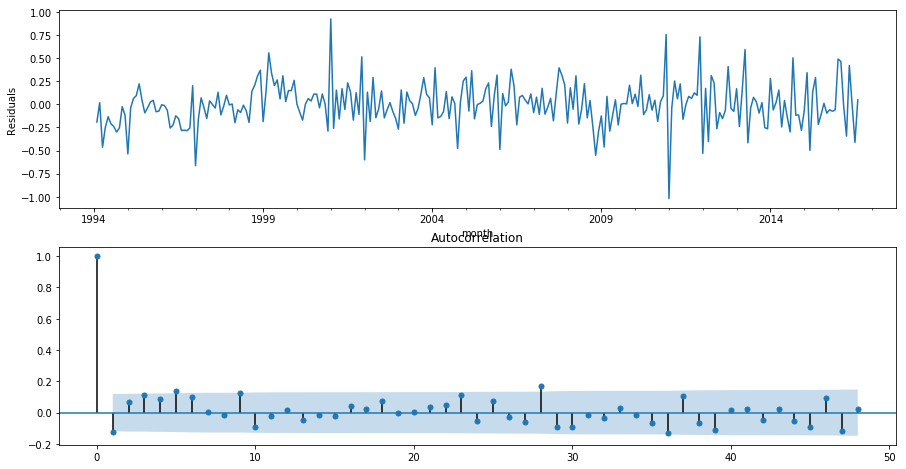

In [13]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % sts.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Автокорреляции нет, тренда нет, остатки не смещены.

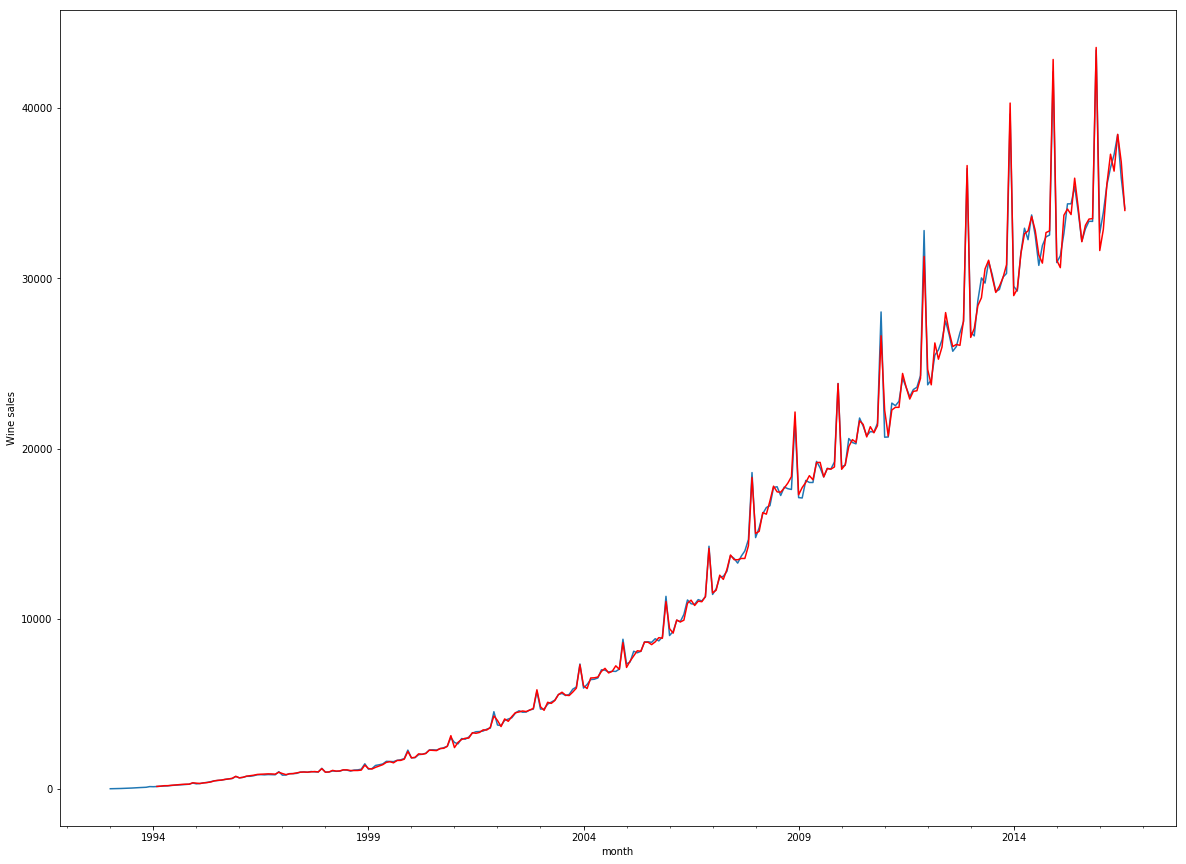

In [14]:
plt.figure(figsize(20,15))
rmw.WAG_C_M.plot()
invboxcox(best_model.fittedvalues, lmbda)[13:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

модель подозрительно хорошо описывает данные

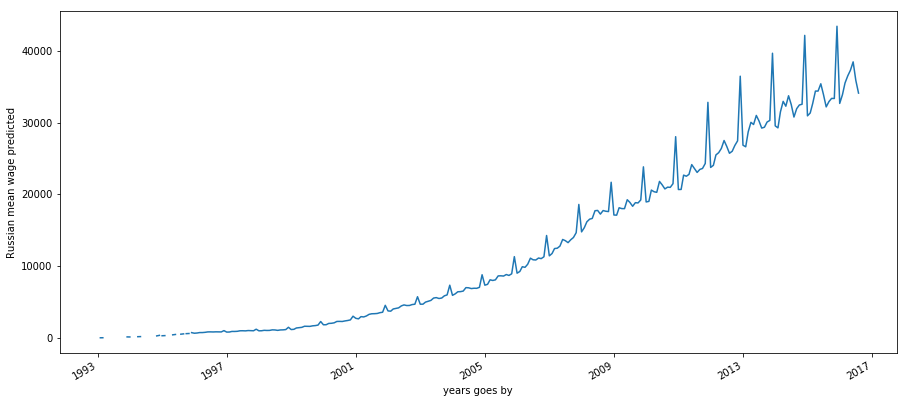

In [66]:
rmw2 = rmw[['WAG_C_M']]
date_list = [datetime.datetime.strptime("1993-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= rmw2.columns)
rmw2 = pd.concat([rmw2, future])
rmw2['forecast'] = invboxcox(best_model.predict(start=284, end=313), lmbda)

plt.figure(figsize(15,7))
rmw2.WAG_C_M.plot()
rmw2.forecast[284:].plot(color='r')
plt.ylabel('Russian mean wage predicted')
plt.xlabel("years goes by")
plt.show()

Не все могут посмотреть в "будущее", но мы посмотрим. Дата с http://sophist.hse.ru/exes/tables/WAG_M.htm 4 доп месяца 2016, 2017, 2018 до октября(10мес).

In [148]:
future_ = pd.read_html("http://sophist.hse.ru/exes/tables/WAG_M.htm")[0]
rmw3 = future_.iloc[286:313, 3:]

rmw3 = pd.DataFrame(index=date_list,data=rmw3.values, columns=['real'])
rmw3.real = rmw3.real.str.slice(0,-1)
rmw3.real = rmw3.real.astype("float64")

<Figure size 1080x504 with 0 Axes>

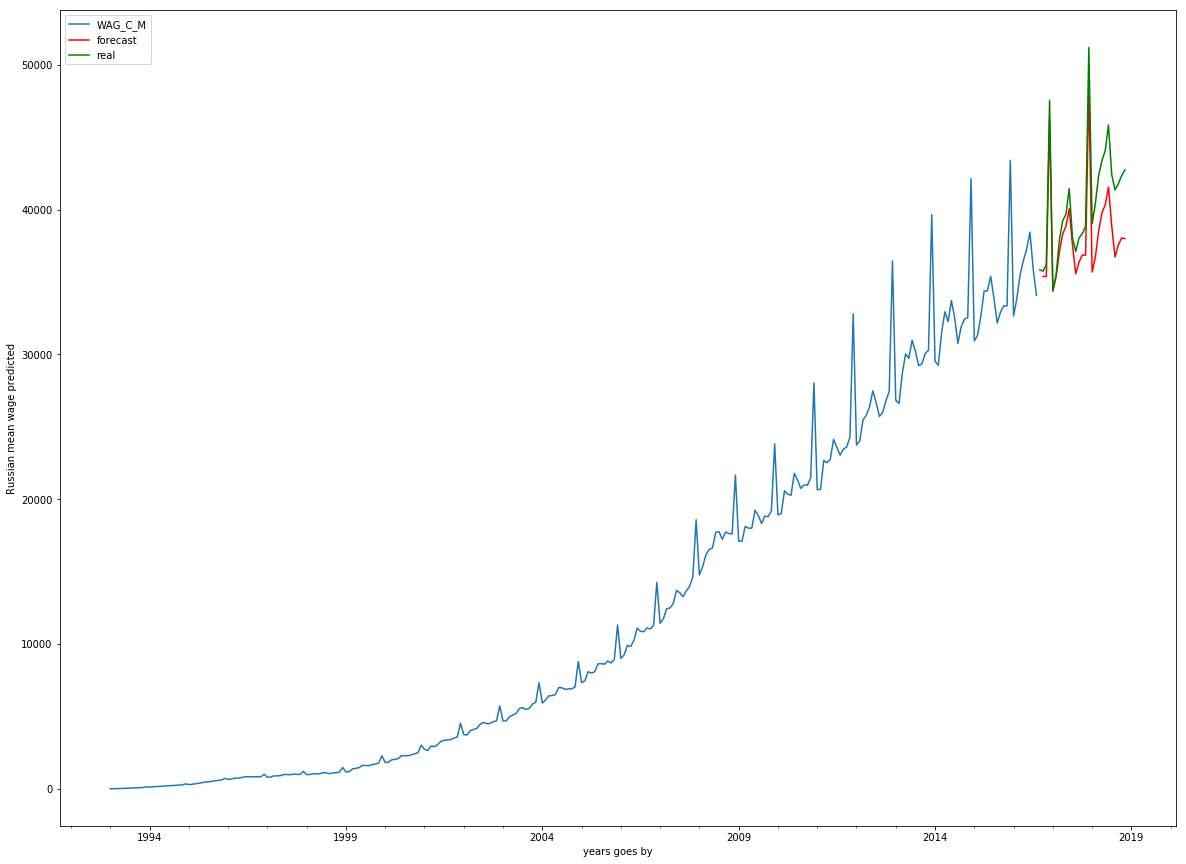

In [146]:
rmw2 = rmw[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,27)]
future = pd.DataFrame(index=date_list, columns= rmw2.columns)
rmw2 = pd.concat([rmw2, future])
rmw2['forecast'] = invboxcox(best_model.predict(start=285, end=311), lmbda)


fig = plt.figure()
plt.figure(figsize(20,15))
rmw2.WAG_C_M.plot()
rmw2.forecast.plot(color='r')
rmw3.real.plot(color='g')
plt.ylabel('Russian mean wage predicted')
plt.xlabel("years goes by")
plt.legend()
plt.show()

Предсказанные значения хорошо предсказывают сезонность, но плохо предсказывают возврастающий тренд, скорее всего наша модель далека от идеальной.  
Скорее всего это из-за "желания предсказать на 2-3 года вперед", у трендов есть свойства ускоряться-замедляться, и чтобы более точно предсказывать данные, нужно выбирать менее длительный период данных для обучения и предсказания. 